In [1]:
from astropy.modeling import models, fitting
from astropy.io import fits
from astropy.modeling.models import custom_model
from astropy.convolution import convolve_models
from scipy.signal import fftconvolve
from astropy.visualization import (
    ImageNormalize,
    MinMaxInterval,
    LogStretch,
    HistEqStretch,
    LinearStretch,
    ZScaleInterval,
)
from photutils.isophote import Ellipse, EllipseGeometry

import numpy as np
import matplotlib
from matplotlib import pyplot as plt

matplotlib.rc("image", interpolation="none", origin="lower")  # , cmap="Greys")
plt.rcParams["figure.constrained_layout.use"] = True


## 读取数据
### 使用`astropy.io.fits`读取数据图像，mask图像，PSF图像，sigma图像

In [2]:
path_data = "NGC2417.fits"
path_mask = "NGC2417_mask.fits"
path_sigma = "NGC2417_sigma.fits"
path_psf = "NGC2417_psf.fits"
data = fits.getdata(path_data, 0) - 144.7065           # 减去背景
x, y = np.meshgrid(np.arange(data.shape[1]), np.arange(data.shape[0]))
nx = data.shape[1]
ny = data.shape[0]
mask = fits.getdata(path_mask, 0)
sigma = fits.getdata(path_sigma, 0)
weight = 1.0 / sigma
weight[mask == 1] = 0     # 被mask的像素权重设为0
psf = fits.getdata(path_psf, 0)

# sw = 200
# idx = (slice(int(ny/2-sw),int(ny/2+sw)),slice(int(nx/2-sw),int(nx/2+sw)))
# data = data[idx]
# x, y = np.meshgrid(np.arange(data.shape[1]), np.arange(data.shape[0]))
# nx = data.shape[1]
# ny = data.shape[0]
# mask=mask[idx]
# weight=weight[idx]


## 创建自定义卷积后的Sérsic模型

In [3]:
# from statmorph
class ConvolvedSersic(models.Sersic2D):
    """
    Two-dimensional Sersic surface brightness profile, convolved with
    a PSF provided by the user as a numpy array.

    See Also
    --------
    astropy.modeling.models.Sersic2D

    """

    psf = None

    @classmethod
    def set_psf(cls, psf):
        """
        Specify the PSF to be convolved with the Sersic2D model.
        """
        cls.psf = psf / np.sum(psf)  # make sure it's normalized

    @classmethod
    def evaluate(cls, x, y, amplitude, r_eff, n, x_0, y_0, ellip, theta):
        """
        Evaluate the ConvolvedSersic2D model.
        """
        z_sersic = models.Sersic2D.evaluate(
            x, y, amplitude, r_eff, n, x_0, y_0, ellip, theta
        )
        if cls.psf is None:
            raise AssertionError("Must specify PSF using set_psf method.")

        # Apparently, scipy.signal also wants double:
        return fftconvolve(np.float64(z_sersic), np.float64(cls.psf), mode="same")


## 单成分拟合
### 初始化模型（[`Sersic2D`](https://docs.astropy.org/en/stable/api/astropy.modeling.functional_models.Sersic2D.html#astropy.modeling.functional_models.Sersic2D)文档），选取拟合算法（可用的[算法](https://docs.astropy.org/en/stable/modeling/fitting.html)），完成拟合后输出模型查看参数

In [4]:
# 初始化模型
sersic_init = ConvolvedSersic(          
    amplitude=100.0,
    r_eff=100.0,
    n=2.0,
    x_0=890,
    y_0=1000,
    ellip=0.3,
    theta=-20.0 / 180 * np.pi,
)
sersic_init.set_psf(psf)
# 选用Levenberg-Marquardt algorithm，可用的非线性fitter参考 https://docs.astropy.org/en/stable/modeling/fitting.html#notes-on-non-linear-fitting
fit_sersic = fitting.LevMarLSQFitter(calc_uncertainties=True)   
# 开始拟合
sersic_bestfit = fit_sersic(sersic_init, x, y, data, weights=weight, maxiter=1000)
# print(fit_sersic.fit_info["message"])


3258.894442447518
{'amplitude': 52.869024673347475, 'r_eff': 164.5795011068177, 'n': 2.0661959282945337, 'x_0': 895.9859730644565, 'y_0': 1001.2092670370411, 'ellip': 0.2559996651243996, 'theta': -0.05391843248925169}


/Library/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Greys_r").copy()
  # Remove the CWD from sys.path while we load stuff.


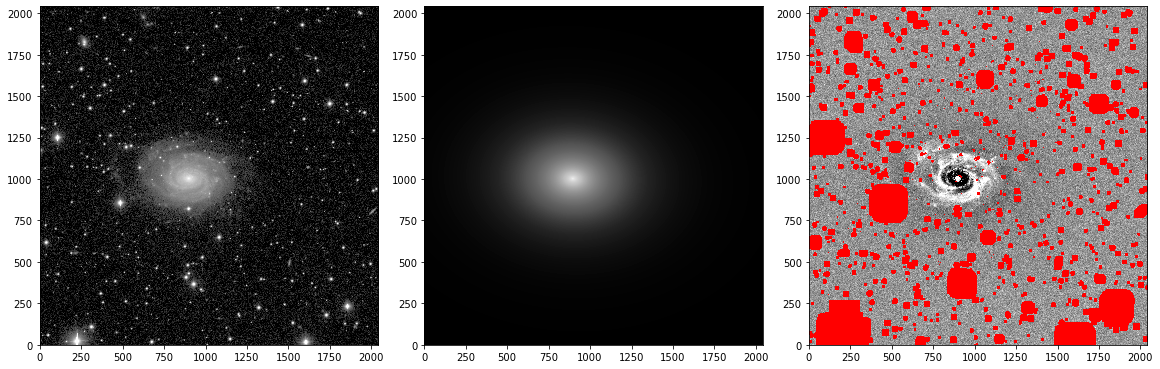

In [5]:
# 打印拟合好的参数
print(np.mean(fit_sersic.fit_info["param_cov"] / fit_sersic.fit_info["cov_x"]))
# print(sersic_bestfit.__dict__)
print(dict(zip(sersic_bestfit.param_names, sersic_bestfit.parameters)))
# 比较数据和模型图像
eval_sersic_bestfit = sersic_bestfit(x, y)
residual = data - eval_sersic_bestfit
residual = np.ma.array(residual, mask=mask)
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
matplotlib.cm.get_cmap("Greys_r").set_bad(color="red")
norm = ImageNormalize(vmin=0, vmax=np.nanmax(data[mask == 0]), stretch=LogStretch())
resi_norm = ImageNormalize(
    residual, stretch=LinearStretch(), interval=ZScaleInterval()
)  # vmin=np.nanmin(residual), vmax=np.nanmax(residual))
axes[0].imshow(data, norm=norm, cmap="Greys_r")
axes[1].imshow(eval_sersic_bestfit, norm=norm, cmap="Greys_r")
axes[2].imshow(residual, norm=resi_norm, cmap="Greys_r")


### 比较数据图像和模型图像的亮度轮廓

#### 使用`photutils.isophote`抽取亮度轮廓

In [6]:
data_masked = np.ma.array(data, mask=mask)
geo = EllipseGeometry(
    x0=sersic_bestfit.x_0.value,
    y0=sersic_bestfit.y_0.value,
    sma=sersic_bestfit.r_eff.value,
    eps=sersic_bestfit.ellip.value,
    pa=sersic_bestfit.theta.value,
)
geo.find_center(data_masked)
ellipse_data = Ellipse(data_masked, geo)
isolist_data = ellipse_data.fit_image(
    fix_center=True, maxsma=sersic_bestfit.r_eff.value * 5
)
ellipse_model = Ellipse(eval_sersic_bestfit, geo)
isolist_model = ellipse_model.fit_image(
    fix_center=True, maxsma=sersic_bestfit.r_eff.value * 5
)
print(isolist_data.to_table())
print(isolist_model.to_table())


INFO: Found center at x0 = 896.0, y0 = 1003.0 [photutils.isophote.geometry]
       sma               intens            intens_err      ... niter stop_code
                                                           ...                
------------------ ------------------ -------------------- ... ----- ---------
               0.0  3542.110107421875                  0.0 ...     0         0
0.5405235644247438  3418.578958469765   24.656170485974666 ...    10         0
0.5945759208672182 3406.5429022009316   27.039497335372648 ...    10         0
0.6540335129539401 3393.3811145690197   29.645921636800644 ...    10         0
0.7194368642493341  3378.938387145361   32.533293714958425 ...    10         0
0.7913805506742675  3361.866365367221   36.033987955150856 ...    10         0
0.8705186057416943 3343.3071793692898   39.884445249875995 ...    10         0
0.9575704663158637 3323.5763188001883   43.815998852594355 ...    10         0
1.0533275129474502 3297.7781209539276    48.15535834807

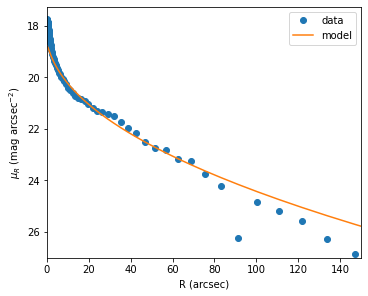

In [7]:
pixel_scale = 0.259
header_R = fits.getheader(path_data, 0)
zpt_R = header_R["zpt_lan"] if header_R["zpt_lan"] != -1 else header_R["zpt_gsc"]
exp_time = header_R["EXPTIME"]
sma_data = isolist_data.sma * pixel_scale
sma_model = isolist_model.sma * pixel_scale
mu_data = -2.5 * np.log10(isolist_data.intens / pixel_scale ** 2 / exp_time) + zpt_R
mu_model = -2.5 * np.log10(isolist_model.intens / pixel_scale ** 2 / exp_time) + zpt_R
f, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(sma_data, mu_data, "o", label="data")
ax.plot(sma_model, mu_model, "-", label="model")
ax.set_xlim(0, 150)
ax.set_ylim(top=27)
ax.set_xlabel("R (arcsec)")
ax.set_ylabel("$\mu_R$ (mag arcsec$^{-2}$)")
ax.invert_yaxis()
ax.legend()


## 二成分拟合

### 初始化模型（Sérsic+Exponential），选取拟合算法，完成拟合后输出模型查看参数

In [8]:
# sersic模型初始化
sersic_init = ConvolvedSersic(
    amplitude=300.0,
    r_eff=10.0,
    n=2.0,
    x_0=900,
    y_0=1000,
    ellip=0.3,
    theta=-20.0 / 180 * np.pi,
)
sersic_init.set_psf(psf)
# exponential模型初始化
exp_init = ConvolvedSersic(
    amplitude=100,
    r_eff=50,
    n=1.0,                # exponential的指数应为1
    x_0=900,
    y_0=1000,
    ellip=0.4,
    theta=-20.0 / 180 * np.pi,
    fixed={"n": True},    # 固定sersic指数
)
exp_init.set_psf(psf)
# 组合模型
sersicplusexp_init = sersic_init + exp_init
# 选取fitter
fit_sersicplusexp = fitting.LevMarLSQFitter(calc_uncertainties=True)
#拟合
sersicplusexp_bestfit = fit_sersicplusexp(
    sersicplusexp_init, x, y, data, weights=weight, maxiter=1000
)


2724.289667080262
{'amplitude_0': 349.47726438920836, 'r_eff_0': 16.913972017571176, 'n_0': 1.6551214461842931, 'x_0_0': 895.8927492705391, 'y_0_0': 1002.0082427980096, 'ellip_0': 0.26455436430999957, 'theta_0': -0.08000286343384685, 'amplitude_1': 73.52157660778887, 'r_eff_1': 147.43398831207077, 'n_1': 1.0, 'x_0_1': 896.7257553670347, 'y_0_1': 999.8066384052897, 'ellip_1': 0.24944999071455382, 'theta_1': -0.06353107609862595}
standard deviations
amplitude_0| 67.928
r_eff_0    | 2.055
n_0        | 0.227
x_0_0      | 0.345
y_0_0      | 0.274
ellip_0    | 0.047
theta_0    | 0.104
amplitude_1| 2.491
r_eff_1    | 2.861
x_0_1      | 1.164
y_0_1      | 0.877
ellip_1    | 0.013
theta_1    | 0.029


/Library/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Greys_r").copy()


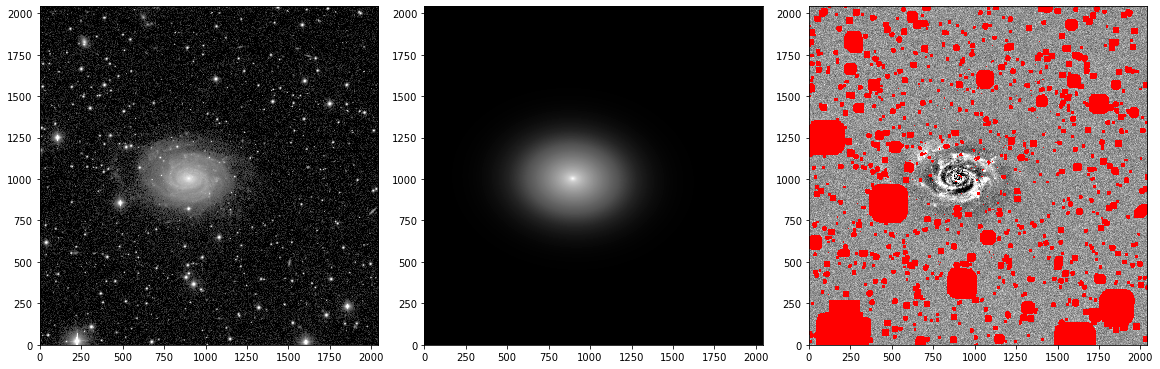

In [9]:
# 打印拟合好的参数
print(
    np.mean(
        fit_sersicplusexp.fit_info["param_cov"] / fit_sersicplusexp.fit_info["cov_x"]
    )
)
# print(sersic_bestfit.__dict__)
print(dict(zip(sersicplusexp_bestfit.param_names, sersicplusexp_bestfit.parameters)))
print(sersicplusexp_bestfit.stds.pprint(100, 3))

# 比较数据和模型图像
eval_sersicplusexp_bestfit = sersicplusexp_bestfit(x, y)
residual = data - eval_sersicplusexp_bestfit
residual = np.ma.array(residual, mask=mask)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
norm = ImageNormalize(vmin=0, vmax=np.nanmax(data[mask == 0]), stretch=LogStretch())
resi_norm = ImageNormalize(
    residual, stretch=LinearStretch(), interval=ZScaleInterval()
)  # , vmin=np.nanmin(residual), vmax=np.nanmax(residual))
matplotlib.cm.get_cmap("Greys_r").set_bad(color="red")
axes[0].imshow(data, norm=norm, cmap="Greys_r")
axes[1].imshow(eval_sersicplusexp_bestfit, norm=norm, cmap="Greys_r")
axes[2].imshow(residual, norm=resi_norm, cmap="Greys_r")


### 比较数据图像和模型图像的亮度轮廓

In [10]:
sersic_param = sersicplusexp_bestfit.parameters[0:7]
exp_param = sersicplusexp_bestfit.parameters[7:]
sersic_bestfit1 = ConvolvedSersic(*sersic_param)
sersic_bestfit1.set_psf(psf)
exp_bestfit1 = ConvolvedSersic(*exp_param)
exp_bestfit1.set_psf(psf)
eval_sersic_bestfit1 = sersic_bestfit1(x, y)
eval_exp_bestfit1 = exp_bestfit1(x, y)
ellipse_sersic1 = Ellipse(eval_sersic_bestfit1, geo)
isolist_sersic1 = ellipse_sersic1.fit_image(
    fix_center=True, maxsma=sersic_bestfit1.r_eff.value * 1.5
)
ellipse_exp1 = Ellipse(eval_exp_bestfit1, geo)
isolist_exp1 = ellipse_exp1.fit_image(
    fix_center=True, maxsma=exp_bestfit1.r_eff.value * 4
)
ellipse_model1 = Ellipse(eval_sersicplusexp_bestfit, geo)
isolist_model1 = ellipse_model1.fit_image(
    fix_center=True, maxsma=exp_bestfit1.r_eff.value * 4
)


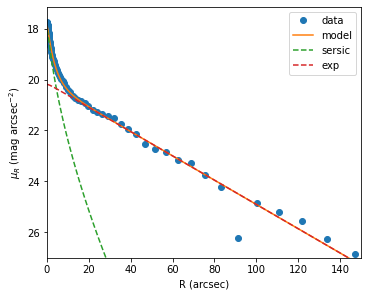

In [11]:
sma_sersic1 = isolist_sersic1.sma * pixel_scale
mu_sersic1 = (
    -2.5 * np.log10(isolist_sersic1.intens / pixel_scale ** 2 / exp_time) + zpt_R
)
sma_exp1 = isolist_exp1.sma * pixel_scale
mu_exp1 = -2.5 * np.log10(isolist_exp1.intens / pixel_scale ** 2 / exp_time) + zpt_R
sma_model1 = isolist_model1.sma * pixel_scale
mu_model1 = -2.5 * np.log10(isolist_model1.intens / pixel_scale ** 2 / exp_time) + zpt_R
f, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(sma_data, mu_data, "o", label="data")
ax.plot(sma_model1, mu_model1, "-", label="model")
ax.plot(sma_sersic1, mu_sersic1, "--", label="sersic")
ax.plot(sma_exp1, mu_exp1, "--", label="exp")
ax.set_xlim(0, 150)
ax.set_ylim(top=27)
ax.set_xlabel("R (arcsec)")
ax.set_ylabel("$\mu_R$ (mag arcsec$^{-2}$)")
ax.invert_yaxis()
ax.legend()
